# EDA: Google Merchandise Store 2016 Q4

## Objective
* Provide a holistic analysis of the Google Merchandise Store in 2016 Q4
* Deliver insights and recommendations to improve performance and inform marketing strategy

* This notebook includes:
    * Developed user segments based on location, device preferences, engagement behavior, and traffic channels
    * Performance analysis and targeting recommendations based on comparison of transaction and engagement KPIs between user segments
    * Site improvement insights based on investigation of web store behavior, engagement, and site performance

## Data Source
[Google Analytics Sample Data](https://www.kaggle.com/datasets/bigquery/google-analytics-sample/data) of the [Google Merchandise Store](https://shop.googlemerchandisestore.com/)

* [Data Dictionary](https://support.google.com/analytics/answer/3437719?hl=en)

### Limitations
* Sample dataset has restricted feature availability
* Detailed information about campaign targeting for this quarter and previous quarters is unavailable, which would likely impact the dataset

## Imports and Client Initialization

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from google.cloud import bigquery
from scipy import stats
import plotly.express as px

In [2]:
# create client
client = bigquery.Client()

## Web Store Performance Overview

In [3]:
query = """
    SELECT
        users,
        new_users,
        new_users / users * 100 AS new_user_perc,
        sessions,
        transactions,
        transactions / sessions * 100 AS conversion_rate,
        revenue,
        revenue / transactions AS AOV,
        bounces / sessions * 100 AS bounce_rate,
        avg_pages,
        avg_duration
    FROM(
        SELECT 
            COUNT(DISTINCT fullVisitorId) AS users,
            SUM(totals.newVisits) AS new_users,
            SUM(totals.visits) as sessions,
            SUM(totals.transactions) AS transactions,
            SUM(totals.totaltransactionRevenue)/1000000 AS revenue,
            SUM(totals.bounces) AS bounces,
            AVG(totals.pageviews) AS avg_pages,
            AVG(totals.timeOnSite) AS avg_duration
        FROM 
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE
            _TABLE_SUFFIX BETWEEN '20161001' AND '20161231'
    )
"""
result = client.query(query)
df = result.to_dataframe()
df.head(10)

,users,new_users,new_user_perc,sessions,transactions,conversion_rate,revenue,AOV,bounce_rate,avg_pages,avg_duration
0,241169,233829,96.956491,290602,3324,1.143832,424630.76,127.746919,50.112181,3.530206,222.056922


In Q4 2016 there were ~241K users, the large majority of which (~97%) were new users. This indicates strong user growth for the store, but perhaps weakness in retaining customers.

3324 transactions were completed, generating ~$425K in revenue, leading to an average order value of ~$128. The conversion rate was ~1.1% [which is about average](https://business.adobe.com/blog/basics/ecommerce-conversion-rate-benchmarks#:~:text=On%20average%2C%20ecommerce%20websites%20should,your%20business%20to%20other%20industries.), but should be a target for improvement. 

The bounce rate was ~50%, which is higher than the [average B2C bounce rate of 45%](https://www.fullstory.com/blog/what-is-a-good-bounce-rate/#:~:text=It%20depends%20on%20your%20industry,explore%20more%20of%20your%20website). The average number of page views was ~3.5 and the average duration of non-bounced sessions was ~220 seconds. These KPIs indicate moderate user engagement, which should be targeted for improvement in order to drive more conversions and revenue.

## User Insights
Objective: Analyze users demographics and device preferences to identify market segments and inform future campaigns.

### Location
Lets investigate where our users are from geographically

In [4]:
query = """
    SELECT
        country,
        users,
        new_users,
        new_users / users * 100 AS new_user_perc,
        sessions,
        transactions,
        transactions / sessions * 100 AS conversion_rate,
        revenue,
        revenue / transactions AS AOV,
        bounces / sessions * 100 AS bounce_rate,
        avg_duration
    FROM(
        SELECT 
            geoNetwork.country AS country,
            COUNT(DISTINCT fullVisitorId) AS users,
            SUM(totals.newVisits) AS new_users,
            SUM(totals.visits) as sessions,
            SUM(totals.transactions) AS transactions,
            SUM(totals.totaltransactionRevenue)/1000000 AS revenue,
            SUM(totals.bounces) AS bounces,
            AVG(totals.timeOnSite) AS avg_duration
        FROM 
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE
            _TABLE_SUFFIX BETWEEN '20161001' AND '20161231'
        GROUP BY
            country
        ORDER BY 
            users DESC
    )
"""
result = client.query(query)
df = result.to_dataframe()
df.head(10)

,country,users,new_users,new_user_perc,sessions,transactions,conversion_rate,revenue,AOV,bounce_rate,avg_duration
0,United States,70037,64670,92.336908,99176,3160,3.186255,402571.28,127.395975,32.485682,283.015023
1,Vietnam,18827,18788,99.792851,19551,<NA>,NaN,NaN,NaN,59.372922,47.769328
2,India,14127,14014,99.200113,15386,3,0.019498,351.83,117.276667,55.173534,165.226074
3,Thailand,13926,13859,99.518886,14646,1,0.006828,152.90,152.900000,62.569985,70.922431
4,Turkey,9670,9570,98.965874,10228,1,0.009777,91.95,91.950000,66.797028,84.561708
5,Brazil,9488,9428,99.367622,10132,3,0.029609,117.35,39.116667,69.591394,137.281626
6,United Kingdom,8016,7819,97.542415,9318,8,0.085855,570.10,71.262500,60.399227,193.112982
7,Canada,5431,5168,95.157430,7411,72,0.971529,10889.01,151.236250,34.070976,297.411777
8,Mexico,4745,4649,97.976818,5175,8,0.154589,554.50,69.312500,62.763285,156.666667
9,Japan,4533,4458,98.345467,5346,3,0.056117,104.92,34.973333,56.004489,228.222506


In [5]:
#visualize users with choropleth
fig = px.choropleth(df,
                    locations="country",
                    locationmode="country names",
                    color="users",
                    hover_name="country",
                    color_continuous_scale="Viridis")
fig.show()

In [6]:
# sort by revenue
df.sort_values("revenue", ascending=False).head(10)

,country,users,new_users,new_user_perc,sessions,transactions,conversion_rate,revenue,AOV,bounce_rate,avg_duration
0,United States,70037,64670,92.336908,99176,3160,3.186255,402571.28,127.395975,32.485682,283.015023
7,Canada,5431,5168,95.157430,7411,72,0.971529,10889.01,151.236250,34.070976,297.411777
85,Kenya,146,144,98.630137,191,2,1.047120,3693.30,1846.650000,52.356021,245.898876
84,Puerto Rico,147,142,96.598639,213,5,2.347418,675.16,135.032000,34.272300,378.300000
6,United Kingdom,8016,7819,97.542415,9318,8,0.085855,570.10,71.262500,60.399227,193.112982
8,Mexico,4745,4649,97.976818,5175,8,0.154589,554.50,69.312500,62.763285,156.666667
28,Israel,1498,1466,97.863818,1925,2,0.103896,501.90,250.950000,54.025974,244.633787
11,Indonesia,3863,3842,99.456381,4085,3,0.073439,480.83,160.276667,58.751530,116.178635
62,Ecuador,361,350,96.952909,387,2,0.516796,474.06,237.030000,68.217054,210.349593
32,Hong Kong,1204,1183,98.255814,1371,2,0.145879,463.90,231.950000,52.954048,183.069876


United States represented the largest amount of users (~70K) and generated revenue (~$403K), and highest conversion rate (~3.2%) indicating strong performance in this market. The US also had the lowest bounce rate (~32%) and high average page views (~5.8) when compared to other Top 10 countries (by both revenue and number of users).

Canada generated the second highest amount of revenue (~$11k) with a conversion rate of ~1.0% and AOV of ~$151, despite ranking 7th for total users (~5k). Canada also had a similar bounce rate (~34%) and average page views (~5.5) to the US. There's potential value in targeting Canada for future user growth. 

Puerto Rico could also be a target for future user growth, with a conversion rate of ~2.3% and comparable engagement statistics to the US and Canada (~34% bounce rate and ~6.4 average page views), and the highest average non-bounced session duration (~380 seconds). In Q4 2016 Puerto Rico generated 5 transactions from 147 users, representing ~$675 in revenue and an AOV of ~$135. Puerto Rico ranked 84th in terms of users and 4th in terms of revenue (although still very far behind the US). Due to a low sample size of users these indicators could be anomolous. Furthermore, Puerto Rico is a much smaller market in comparison to the United States and Canada. Nevertheless, there is potential value in further user and market research for this location.

A significant amount of users were located in Vietnam (~19K), India (~14K), and Thailand (~14K). The existing user base and market size in India and SEA suggests that further market and user research could be valuable in these regions, despite poor performance in conversion rates and engagement statistics. 

### Device Analysis

#### Device Types

In [7]:
query = """
    SELECT
        device,
        users,
        new_users,
        new_users / users * 100 AS new_user_perc,
        sessions,
        transactions,
        transactions / sessions * 100 AS conversion_rate,
        revenue,
        revenue / transactions AS AOV,
        bounces / sessions * 100 AS bounce_rate,
        avg_pages,
        avg_duration
    FROM(
        SELECT
            device.deviceCategory AS device,
            COUNT(DISTINCT fullVisitorId) AS users,
            SUM(totals.newVisits) AS new_users,
            SUM(totals.visits) as sessions,
            SUM(totals.transactions) AS transactions,
            SUM(totals.totaltransactionRevenue)/1000000 AS revenue,
            SUM(totals.bounces) AS bounces,
            AVG(totals.pageviews) AS avg_pages,
            AVG(totals.timeOnSite) AS avg_duration
        FROM
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE
            _TABLE_SUFFIX BETWEEN '20161001' AND '20161231'
        GROUP BY
            device
        ORDER BY
            users DESC
    )
"""

result = client.query(query)
df = result.to_dataframe()
df.head()

,device,users,new_users,new_user_perc,sessions,transactions,conversion_rate,revenue,AOV,bounce_rate,avg_pages,avg_duration
0,desktop,194563,188112,96.684364,231931,3012,1.298662,401401.72,133.267503,50.364979,3.491238,218.229886
1,mobile,40172,39439,98.175346,50619,249,0.491910,19713.52,79.170763,49.279915,3.623469,234.714074
2,tablet,6434,6278,97.575381,8052,63,0.782414,3515.52,55.801905,48.062593,4.066319,249.719799


The majority of users were on desktop devices (~194k). Desktop users also represented the large majority of revenue generated (~$401k), a significantly higher converstion rate (~1.3%), and AOV ~$133. It's possible that the conversion path and payment experience is better optimized on desktop devices.

The percentage of new users was similarly high (>96%) for all device types. Engagement statistics were also similar across device types (~48-50% bounce rate, ~3.5-4 average page views, ~220-250 average session duration), meaning it's unlikely there is compatability/loading/visualization issues on a specific device type.

#### Browsers

In [8]:
query = """
    SELECT
        browser,
        users,
        new_users,
        new_users / users * 100 AS new_user_perc,
        sessions,
        transactions,
        transactions / sessions * 100 AS conversion_rate,
        revenue,
        revenue / transactions AS AOV,
        bounces / sessions * 100 AS bounce_rate,
        avg_pages,
        avg_duration
    FROM(
        SELECT 
            device.Browser AS browser,
            COUNT(DISTINCT fullVisitorId) AS users,
            SUM(totals.newVisits) AS new_users,
            SUM(totals.visits) as sessions,
            SUM(totals.transactions) AS transactions,
            SUM(totals.totaltransactionRevenue)/1000000 AS revenue,
            SUM(totals.bounces) AS bounces,
            AVG(totals.pageviews) AS avg_pages,
            AVG(totals.timeOnSite) AS avg_duration
        FROM 
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE
            _TABLE_SUFFIX BETWEEN '20161001' AND '20161231'
        GROUP BY 
            browser
        ORDER BY 
            users DESC
        LIMIT 10
    )
"""

result = client.query(query)
df = result.to_dataframe()
df.head(10)

,browser,users,new_users,new_user_perc,sessions,transactions,conversion_rate,revenue,AOV,bounce_rate,avg_pages,avg_duration
0,Chrome,147968,141483,95.617296,188100,2952,1.569378,395634.90,134.022663,47.189261,4.060491,249.464954
1,Safari,70494,69819,99.042472,76844,248,0.322732,19571.11,78.915766,54.847483,2.485308,141.566110
2,Firefox,8323,8191,98.414033,9793,55,0.561626,4557.22,82.858545,57.786174,3.015320,270.654117
3,Internet Explorer,4942,4885,98.846621,5414,41,0.757296,1695.32,41.349268,55.448836,2.890963,204.142976
4,Edge,2317,2273,98.100993,2737,20,0.730727,2953.43,147.671500,53.050786,3.240044,222.507405
5,Opera,1822,1816,99.670692,1942,1,0.051493,64.97,64.970000,55.303811,2.084964,230.132641
6,Opera Mini,1442,1438,99.722607,1497,<NA>,NaN,NaN,NaN,59.318637,2.219773,205.533113
7,Safari (in-app),1319,1310,99.317665,1421,3,0.211119,48.92,16.306667,56.087262,2.534835,166.204180
8,Android Webview,673,657,97.622585,731,3,0.410397,67.90,22.633333,55.129959,2.938440,188.033742
9,YaBrowser,602,597,99.169435,626,<NA>,NaN,NaN,NaN,70.607029,1.659744,182.693989


Majority of users (~148K) were using Chrome as their browser. Chrome performed well across the board, with the highest conversion rate (~1.6%), highest revenue generation (~$396K), second higest AOV (~$134), lowest bounce rate (~47%),  highest average page views (~4.1), and second highest non-bounced average session duration (~250 secs). This is expected as users of Google's browser would be more engaged and more likely to purchase Google merchandise. The majority of returning users were from Chrome, with the lowest new user rate of ~96%. This further indicates high engagement and also suggests potential for repeat customers. 

Safari also represented a significant amount of users (~70K). Despite Safari's significant amount of users, the conversion rate (0.3%) and average session duration (~142 secs) is significantly lower when compared to other top 5 browsers by users.

#### OS

In [9]:
query = """
    SELECT
        OS,
        users,
        new_users,
        new_users / users * 100 AS new_user_perc,
        sessions,
        transactions,
        transactions / sessions * 100 AS conversion_rate,
        revenue,
        revenue / transactions AS AOV,
        bounces / sessions * 100 AS bounce_rate,
        avg_pages,
        avg_duration
    FROM(
        SELECT 
            device.operatingSystem AS OS,
            COUNT(DISTINCT fullVisitorId) AS users,
            SUM(totals.newVisits) AS new_users,
            SUM(totals.visits) as sessions,
            SUM(totals.transactions) AS transactions,
            SUM(totals.totaltransactionRevenue)/1000000 AS revenue,
            SUM(totals.bounces) AS bounces,
            AVG(totals.pageviews) AS avg_pages,
            AVG(totals.timeOnSite) AS avg_duration
        FROM 
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE
            _TABLE_SUFFIX BETWEEN '20161001' AND '20161231'
        GROUP BY 
            OS
        ORDER BY 
            users DESC
        LIMIT 10
    )
"""

result = client.query(query)
df = result.to_dataframe()
df.head(10)

,OS,users,new_users,new_user_perc,sessions,transactions,conversion_rate,revenue,AOV,bounce_rate,avg_pages,avg_duration
0,Windows,101261,99402,98.164150,117102,713,0.608871,99895.06,140.105273,55.981110,2.882174,210.889211
1,Macintosh,82194,78623,95.655401,99623,1856,1.863024,234109.73,126.136708,45.920119,3.847301,212.239099
2,Android,23993,23585,98.299504,30375,138,0.454321,14167.66,102.664203,50.189300,3.593105,242.366402
3,iOS,20715,20235,97.682839,26198,166,0.633636,8688.04,52.337590,47.202076,3.879189,230.795759
4,Linux,6850,6116,89.284672,8763,189,2.156796,13041.62,69.003280,37.179048,4.952756,218.555353
5,Chrome OS,4630,4244,91.663067,6768,262,3.871158,54728.65,208.887977,35.520095,6.922281,382.128647
6,(not set),1104,1099,99.547101,1167,<NA>,NaN,NaN,NaN,57.069409,2.300771,224.949698
7,Windows Phone,318,313,98.427673,377,<NA>,NaN,NaN,NaN,61.007958,2.496021,209.924658
8,BlackBerry,68,67,98.529412,70,<NA>,NaN,NaN,NaN,71.428571,2.100000,210.600000
9,Samsung,61,61,100.000000,61,<NA>,NaN,NaN,NaN,63.934426,2.049180,116.428571


Most desktop users are on Windows (~101K) or Macintosh (~82K). Macintosh has a significantly higher conversion rate (~1.9%) compared to Windows (~0.6%). Macintosh also has a lower bounce rate (~46%) and higher average page views (~3.8) compared to windows (~56%, ~2.9).

Most mobile/tablet users are on Android (~24k) or iOS(~21K). The engagement stats are similar between Android (~50% bounce rate and ~3.6 average page views) and iOS (~47% bounce rate and ~3.9 average page views). Likewise the conversion rates between iOS (~0.6%) and Android (~0.5%) are similar. Android had a much larger AOV of ~$103 compared to iOS AOV of ~$52.

Chrome OS represents a small amount of users (~5K) but had the highest conversion rate (~3.9%), highest AOV (~$208), lowest bounce rate (~36%), highest average page views (~6.9), and longest average session duration (~382 secs). Similar to Chrome browser users, we expect Chrome OS users to be more engaged with and more likely to make a purchase from the Google Merchandise store.

It is interesting to see a conversion rate of ~0.3% for Safari browser and  ~1.9% for Macintosh users. Let's look at the intersection of Desktop OS and browsers to see if there is significant variations between different browsers of Macintosh and Windows users.

In [10]:
query = """
    SELECT
        OS,
        browser,
        users,
        new_users,
        new_users / users * 100 AS new_user_perc,
        sessions,
        transactions,
        transactions / sessions * 100 AS conversion_rate,
        revenue,
        revenue / transactions AS AOV,
        bounces / sessions * 100 AS bounce_rate,
        avg_pages,
        avg_duration
    FROM(
        SELECT 
            device.operatingSystem AS OS,
            device.Browser AS browser,
            COUNT(DISTINCT fullVisitorId) AS users,
            SUM(totals.newVisits) AS new_users,
            SUM(totals.visits) as sessions,
            SUM(totals.transactions) AS transactions,
            SUM(totals.totaltransactionRevenue)/1000000 AS revenue,
            SUM(totals.bounces) AS bounces,
            AVG(totals.pageviews) AS avg_pages,
            AVG(totals.timeOnSite) AS avg_duration
        FROM 
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE
            _TABLE_SUFFIX BETWEEN '20161001' AND '20161231'
            AND device.deviceCategory = "desktop"
        GROUP BY 
            OS, browser
        ORDER BY 
            users DESC
        LIMIT 10
    )
"""

result = client.query(query)
df = result.to_dataframe()
df.head(10)

,OS,browser,users,new_users,new_user_perc,sessions,transactions,conversion_rate,revenue,AOV,bounce_rate,avg_pages,avg_duration
0,Windows,Chrome,85011,83338,98.032019,98889,607,0.613820,91127.31,150.127364,55.644207,2.901698,207.065468
1,Macintosh,Safari,52959,52675,99.463736,54732,113,0.206461,12693.56,112.332389,57.969743,1.910342,96.407618
2,Macintosh,Chrome,28102,24854,88.442104,43399,1734,3.995484,220950.96,127.422699,30.652780,6.290998,298.683616
3,Windows,Firefox,6467,6382,98.685635,7424,44,0.592672,4054.03,92.137045,59.900323,2.860973,265.477058
4,Linux,Chrome,5952,5246,88.138441,7747,188,2.426746,13031.63,69.317181,34.232606,5.237511,216.908376
5,Chrome OS,Chrome,4630,4244,91.663067,6768,262,3.871158,54728.65,208.887977,35.520095,6.922281,382.128647
6,Windows,Internet Explorer,4518,4470,98.937583,4935,33,0.668693,1321.98,40.060000,55.602837,2.841038,197.563387
7,Windows,Edge,2235,2191,98.031320,2631,20,0.760167,2953.43,147.671500,52.603573,3.274800,222.508434
8,Windows,Opera,1628,1628,100.000000,1729,1,0.057837,64.97,64.970000,56.159630,1.950260,237.607662
9,Macintosh,Firefox,1056,1022,96.780303,1410,9,0.638298,465.21,51.690000,48.156028,3.856738,305.060274


The leading conversion rate (~4.0%) and lowest bounce rate (~31%) was Macintosh+Chrome users. This group represented ~28k users. There were more Macintosh+Safari users (~53k), however this group had one of the lowest conversion rates (~0.2%), highest bounce rates (~58%), lowest average page views (~1.9), lowest average session duration (~100 secs).

Windows users predominately used Chrome browser (~85K). There was only small variations in conversion rates and engagement statistics of different Windows+{browser} user groups. Among Windows users, Windows+Chrome had the highest AOV (~$150), followed closely by Windows+Edge(~$148).

100% of Chrome OS users also used the Chrome browser. This is a known restriction of Chrome OS (until 2019). 

Based on this evidence, it would be more valuable to target Chrome browser users rather than users of a specific operating system.

## Behavior and Engagement Analysis
Objective: Analyze behavior patterns and user engagement to inform store strategy and site design.

### Most viewed pages
Rolled up to path level 1

In [11]:
query = """
    SELECT 
        hits.page.pagePathLevel1 AS page_category,
        COUNT(*) AS views,
        SUM(CAST(hits.isExit AS int))/COUNT(*) * 100 AS exit_rate
    FROM 
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
        UNNEST(hits) AS hits
    WHERE
        _TABLE_SUFFIX BETWEEN '20161001' AND '20161231'
    AND
        hits.type='PAGE'
    GROUP BY
        page_category
    ORDER BY
        views DESC
    LIMIT 10
"""

result = client.query(query)
df = result.to_dataframe()
df.head(10)

,page_category,views,exit_rate
0,/google+redesign/,467770,19.230391
1,/home,351945,45.956613
2,/basket.html,61682,9.959145
3,/signin.html,31819,37.757315
4,/store.html,22659,12.988217
5,/asearch.html,17100,30.549708
6,/yourinfo.html,10249,9.483852
7,/payment.html,9259,8.294632
8,/ordercompleted.html,6927,38.559261
9,/store-policies/,6058,39.138329


General store pages (/google+redesign/ category) had the highest number of page views (~468K total), followed by the home page (~352K total). 

Basket, customer information, and payment pages had low exit rates (~8-10%). This suggests high intent to complete transactions for users with items in basket.

#### Store Categories

In [12]:
query = """
    SELECT 
        hits.page.pagePathLevel2 AS page,
        COUNT(*) AS views,
        SUM(CAST(hits.isExit AS int))/COUNT(*) * 100 AS exit_rate
    FROM 
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
        UNNEST(hits) AS hits
    WHERE
        _TABLE_SUFFIX BETWEEN '20161001' AND '20161231'
    AND
        hits.type='PAGE'
    AND
        hits.page.pagePathLevel1 = '/google+redesign/'
    GROUP BY
        page
    ORDER BY
        views DESC
    LIMIT 10
"""

result = client.query(query)
df = result.to_dataframe()
df.head(10)

,page,views,exit_rate
0,/apparel/,139019,19.044879
1,/shop+by+brand/,61609,38.637212
2,/bags/,53043,11.537809
3,/accessories/,43822,9.739400
4,/electronics/,38675,14.857143
5,/office/,30200,13.023179
6,/drinkware/,18031,13.720814
7,/apparel,17915,20.078147
8,/office,12496,18.717990
9,/electronics,12188,23.966196


Apparel is the most popular category of the store with ~139K views.

Shop By Brand is the second most popular with ~62K views, but has a significantly higher exit rate (~39%) compared to the other top 10.

#### Shop By Brand Category
Let's investigate the high exit rate for the "shop by brand" category

In [13]:
query = """
    SELECT 
        hits.page.pagePath AS page,
        COUNT(*) AS views,
        SUM(CAST(hits.isExit AS int))/COUNT(*) * 100 AS exit_rate
    FROM 
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
        UNNEST(hits) AS hits
    WHERE
        _TABLE_SUFFIX BETWEEN '20161001' AND '20161231'
    AND
        hits.type='PAGE'
    AND
        hits.page.pagePathLevel1 = '/google+redesign/'
    AND
        hits.page.pagePathLevel2 = '/shop+by+brand/'
    GROUP BY
        page
    ORDER BY
        views DESC
    LIMIT 10
"""

result = client.query(query)
df = result.to_dataframe()
df.head(10)

,page,views,exit_rate
0,/google+redesign/shop+by+brand/youtube,34946,49.476335
1,/google+redesign/shop+by+brand/google,12835,27.432801
2,/google+redesign/shop+by+brand/android,6660,28.543544
3,/google+redesign/shop+by+brand/youtube/quickview,4943,15.557354
4,/google+redesign/shop+by+brand/google/quickview,1179,13.316370
5,/google+redesign/shop+by+brand/android/quickview,693,9.956710
6,/google+redesign/shop+by+brand/quickview,187,13.903743
7,/google+redesign/shop+by+brand/waze/waze+mood+...,59,47.457627
8,/google+redesign/shop+by+brand/waze+baby+on+bo...,50,38.000000
9,/google+redesign/shop+by+brand/waze+mood+happy...,30,43.333333


The majority of "Shop by Brand" category views came from the youtube category page (~35k) with a high exit rate of ~49%. 

Possible explanations for the high exit rate:
1. There's a visual/loading issue with this page
2. Users do not like the merchandise on this page
3. Users are not seeing the products they expect to (perhaps they expect specific youtuber merchandise).

### Entry Pages and Bounce Rates

Let's explore the bounce rates for entrance pages

In [14]:
query = """
    SELECT 
        hits.page.pagePathLevel1 AS page_category,
        COUNT(*) AS entrance_views,
        SUM(totals.bounces)/SUM(totals.visits) * 100 AS bounce_rate
    FROM 
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
        UNNEST(hits) AS hits
    WHERE
        _TABLE_SUFFIX BETWEEN '20161001' AND '20161231'
    AND
        hits.type='PAGE'
    AND
        hits.isEntrance = True
    GROUP BY
        page_category
    ORDER BY
        entrance_views DESC
    LIMIT 10
"""

result = client.query(query)
df = result.to_dataframe()
df.head(10)

,page_category,entrance_views,bounce_rate
0,/home,229306,50.740495
1,/google+redesign/,49885,49.141024
2,/signin.html,4078,39.087788
3,/basket.html,2507,43.358596
4,/home-2,1314,11.035008
5,/store.html,1148,54.529617
6,/google redesign/,798,48.997494
7,/asearch.html,780,66.153846
8,/store-policies/,504,64.484127
9,/myaccount.html?mode=billingaddress,75,2.666667


The majority of entrances (~229K) were to the home page with a bounce rate of ~51%, followed by the store pages category (~50k) with a similar bounce rate of ~49%. The home page and store pages should be reviewed to improve engagement, ultimately leading to more conversions and revenue.

#### Store Categories

In [15]:
query = """
        SELECT 
            hits.page.pagePathLevel2 AS store_category,
            COUNT(*) AS entrance_views,
            SUM(totals.bounces)/SUM(totals.visits) * 100 AS bounce_rate
        FROM 
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
            UNNEST(hits) AS hits
        WHERE
            _TABLE_SUFFIX BETWEEN '20161001' AND '20161231'
        AND
            hits.type='PAGE'
        AND
            hits.isEntrance = True
        AND
            hits.page.pagePathLevel1 = '/google+redesign/'
        GROUP BY
            store_category
        ORDER BY
            entrance_views DESC
        LIMIT 10
        """

result = client.query(query)
df = result.to_dataframe()
df.head(10)

,store_category,entrance_views,bounce_rate
0,/apparel/,17984,47.191948
1,/shop+by+brand/,14216,49.310636
2,/electronics/,2112,59.659091
3,/drinkware,2095,51.551313
4,/bags,1918,44.264859
5,/bags/,1871,47.675040
6,/apparel,1631,47.087676
7,/office/,1588,54.093199
8,/accessories/,1208,45.612583
9,/drinkware/,1165,50.643777


Apparel (~18K) and shop by brand (~14k) had the highest amount of entrance views. Bounce rates are slightly high across the top 10 ranging from ~44-60%, with electronics performing the worst by this indicator. This suggests that there were no specific product categories with bounce rate outliers, and engagement improvements should be made across all store pages.

### Session Duration

Let's now investigate session duration, removing bounces as their session durations are not calculated by Google Analytics.

In [16]:
query = """
        SELECT 
            totals.timeOnSite AS session_duration
        FROM 
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE
            _TABLE_SUFFIX BETWEEN '20161001' AND '20161231'
        AND
            totals.bounces IS NULL
        """

result = client.query(query)
df = result.to_dataframe()

In [17]:
df[df["session_duration"].isna()]

,session_duration
66,<NA>
95,<NA>
1097,<NA>
1106,<NA>
1125,<NA>
...,...
80859,<NA>
80865,<NA>
80866,<NA>
80891,<NA>


Despite removing bounces, there are still some N/A session durations. This could be due to a multitude of reasons such as timeouts, uncaptured bounces, data capture errors, etc.

Let's remove those N/A values as they're a small proportion of the dataset, and visualize the distribution.

In [18]:
df = df[df["session_duration"].notna()]

c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: xlabel='session_duration', ylabel='Percent'>

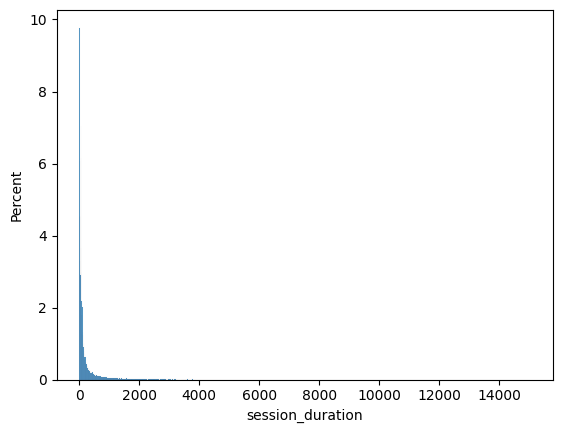

In [19]:
sns.histplot(df["session_duration"], stat='percent')

In [20]:
obs = len(df['session_duration'])
mean = np.round(np.mean(df['session_duration']),1)
median = np.median(df['session_duration'])
std = np.round(np.std(df['session_duration']),1)
mode = stats.mode(df['session_duration']).mode
mode_freq = len(df[df['session_duration']==mode])
min = np.min(df['session_duration'])
q1 = np.percentile(df['session_duration'], 25)
q3 = np.percentile(df['session_duration'], 75)
max = np.max(df['session_duration'])
skew = stats.skew(df['session_duration'])
print("Summary Stats:",
      "\n Observations: ", obs,
      "\n Mean:", mean, "STD:", std,
      "\n Min:", min, "Q1:", q1 , "Median:", median, "Q3:", q3, "Max", max, 
      "\n Mode:", mode, "frequency", mode_freq,
      "\n Skew:", skew)

Summary Stats: 
 Observations:  144690 
 Mean: 222.1 STD: 444.8 
 Min: 1 Q1: 27.0 Median: 62.0 Q3: 193.0 Max 15047 
 Mode: 4 frequency 3855 
 Skew: 5.104936465578142


Session duration is highly positively skewed and there are significant outliers, one session even lasting 15047 seconds (over 4 hours!). These outliers have inflated the mean to ~222 seconds. The standard deviation of ~444 seconds indicates high variability of session times.

In this case the median is a better indicator of centrality, at 62 seconds it shows that the typical session is quite short.  Let's focus on data below the 75th quantile to view more typical user behaviour.

c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: xlabel='session_duration', ylabel='Percent'>

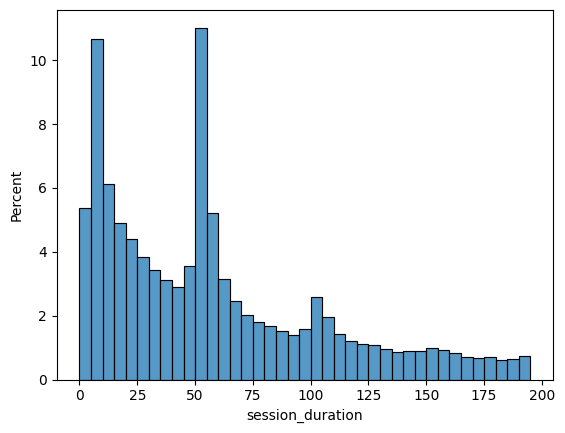

In [21]:
sns.histplot(df["session_duration"], stat='percent', binrange=(0,q3), binwidth=5)

We can see three distinct peaks around 5-10 seconds, 50-55 seconds, and 100-105 seconds. These groups could indicate sessions with different levels of intent. Let's propose four groups of session durations, and investigate their conversion rates
1. 0-44 seconds
2. 45-94 seconds
3. 95-193 seconds
4. \>193 seconds

In [22]:
query = """
    SELECT
        session_group,
        users,
        new_users / users * 100 AS new_user_perc,
        sessions,
        transactions,
        transactions / sessions * 100 AS conversion_rate,
        revenue,
        revenue / transactions AS AOV,
        avg_pages,
        avg_duration
    FROM(
        SELECT
            CASE
                WHEN totals.timeOnSite < 45 THEN '0-44 sec'
                WHEN (totals.timeOnSite >= 44 AND totals.timeOnSite < 95) THEN '45-94 sec'
                WHEN (totals.timeOnSite >= 95 AND totals.timeOnSite < 194) THEN '95-193 sec'
                WHEN (totals.timeOnSite >= 194) THEN '>193 sec'
                ELSE 'error' 
            END AS session_group,
            COUNT(DISTINCT fullVisitorId) AS users,
            SUM(totals.newVisits) AS new_users,
            SUM(totals.visits) as sessions,
            SUM(totals.transactions) AS transactions,
            SUM(totals.totaltransactionRevenue)/1000000 AS revenue,
            AVG(totals.pageviews) AS avg_pages,
            AVG(totals.timeOnSite) AS avg_duration
        FROM 
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE
            _TABLE_SUFFIX BETWEEN '20161001' AND '20161231'
        AND
            totals.bounces IS NULL
        AND
            totals.timeOnSite IS NOT NULL
        GROUP BY
            session_group
        ORDER BY 
            session_group DESC
    )
"""

result = client.query(query)
df = result.to_dataframe()
df.head()

,session_group,users,new_user_perc,sessions,transactions,conversion_rate,revenue,AOV,avg_pages,avg_duration
0,>193 sec,29953,80.232364,36137,3214,8.893931,413878.36,128.773603,13.877408,717.757728
1,95-193 sec,22100,82.461538,23020,108,0.469157,10619.10,98.325000,5.689835,133.297003
2,45-94 sec,35681,87.388246,36813,<NA>,NaN,NaN,NaN,3.330698,61.436069
3,0-44 sec,45131,84.990361,48720,1,0.002053,104.33,104.330000,2.558648,17.686002


Sessions in the outlier group (>193 seconds) had a far higher conversion rate (~9%) and were slightly less likely to be a new user (~80%). This demonstrates a strong positive relationship between session duration and intent to purchase.

Let's investigate if sessions with quick exits (group 1) were entering on different landing pages than other sessions.

In [23]:
query = """
        SELECT 
            hits.page.pagePathLevel1 AS page_category,
            COUNT(*) AS entrance_views
        FROM 
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
            UNNEST(hits) AS hits
        WHERE
            _TABLE_SUFFIX BETWEEN '20161001' AND '20161231'
        AND
            hits.type='PAGE'
        AND
            hits.isEntrance = True
        AND
            totals.bounces IS NULL
        AND
            totals.timeOnSite < 45
        GROUP BY
            page_category
        ORDER BY
            entrance_views DESC
        LIMIT 10
        """

result = client.query(query)
df = result.to_dataframe()
df.head()

,page_category,entrance_views
0,/home,39740
1,/google+redesign/,6849
2,/signin.html,1048
3,/basket.html,378
4,/home-2,266


The majority of entrances (~40K) were to the home page, followed by the store pages category (~7k). As previously shown, these two categories were the most common landing page over all sessions. This supports previous commentary that home page and store pages should be reviewed to improve engagement and site navigation, ultimately leading to more transactions and revenue.

Session durations, engagement and conversion can be improved by
1. Review and optimize entrance pages engagement (home and store pages)
2. Review and optimize site navigation
3. Optimize conversion pathways for medium length sessions, where users are showing some engagement and motivation

### User Frequency

Let's investigate the number of sessions by users in 2016 Q4

In [24]:
query = """
    SELECT 
        SUM(totals.visits) as sessions,
    FROM 
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    WHERE
        _TABLE_SUFFIX BETWEEN '20161001' AND '20161231'
    GROUP BY
        fullVisitorId
"""
result = client.query(query)
df = result.to_dataframe()
df.head()

,sessions
0,6
1,98
2,12
3,6
4,6


c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: xlabel='sessions', ylabel='Percent'>

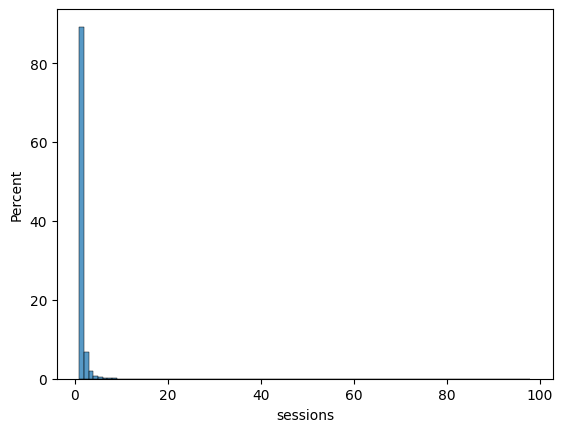

In [25]:
sns.histplot(df["sessions"], stat='percent', binwidth=1)

In [26]:
obs = len(df['sessions'])
mean = np.round(np.mean(df['sessions']),1)
median = np.median(df['sessions'])
std = np.round(np.std(df['sessions']),1)
mode = stats.mode(df['sessions']).mode
mode_freq = len(df[df['sessions']==mode])
min = np.min(df['sessions'])
q1 = np.percentile(df['sessions'], 25)
q3 = np.percentile(df['sessions'], 75)
max = np.max(df['sessions'])
skew = stats.skew(df['sessions'])
print("Summary Stats:",
      "\n Observations: ", obs,
      "\n Mean:", mean, "STD:", std,
      "\n Min:", min, "Q1:", q1 , "Median:", median, "Q3:", q3, "Max", max, 
      "\n Mode:", mode, "frequency", mode_freq,
      "\n Skew:", skew)

Summary Stats: 
 Observations:  241169 
 Mean: 1.2 STD: 1.0 
 Min: 1 Q1: 1.0 Median: 1.0 Q3: 1.0 Max 98 
 Mode: 1 frequency 215231 
 Skew: 23.814293416006603


The majority of users (~89%) had only one session in 2016 Q4. Let's account for bounced sessions by removing them from the results

In [27]:
query = """
    SELECT 
        SUM(totals.visits) as sessions,
    FROM 
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    WHERE
        _TABLE_SUFFIX BETWEEN '20161001' AND '20161231'
    AND
        totals.Bounces IS NULL
    GROUP BY
        fullVisitorId
"""
result = client.query(query)
df = result.to_dataframe()

c:\Users\Nathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: xlabel='sessions', ylabel='Percent'>

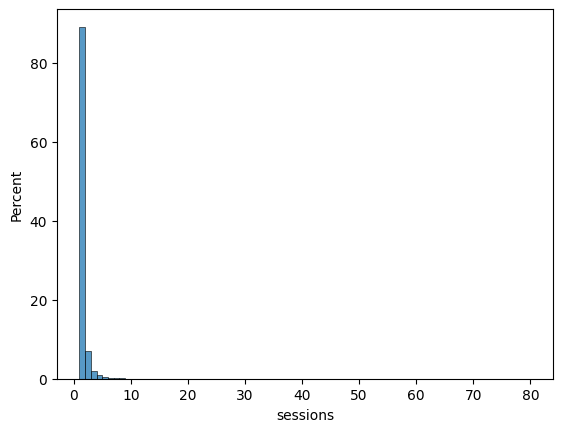

In [28]:
sns.histplot(df["sessions"], stat='percent', binwidth=1)

In [29]:
obs = len(df['sessions'])
mean = np.round(np.mean(df['sessions']),1)
median = np.median(df['sessions'])
std = np.round(np.std(df['sessions']),1)
mode = stats.mode(df['sessions']).mode
mode_freq = len(df[df['sessions']==mode])
min = np.min(df['sessions'])
q1 = np.percentile(df['sessions'], 25)
q3 = np.percentile(df['sessions'], 75)
max = np.max(df['sessions'])
skew = stats.skew(df['sessions'])
print("Summary Stats:",
      "\n Observations: ", obs,
      "\n Mean:", mean, "STD:", std,
      "\n Min:", min, "Q1:", q1 , "Median:", median, "Q3:", q3, "Max", max, 
      "\n Mode:", mode, "frequency", mode_freq,
      "\n Skew:", skew)

Summary Stats: 
 Observations:  121089 
 Mean: 1.2 STD: 0.9 
 Min: 1 Q1: 1.0 Median: 1.0 Q3: 1.0 Max 80 
 Mode: 1 frequency 107841 
 Skew: 20.34157296042013


The results hold when bounced sessions are removed, the majority of non-bounced users (~89%) had only one session in 2016 Q4. Let's group non-bounced users by number of sessions (1 vs 2+) and compare statistics.

In [30]:
query = """
    WITH stats_per_user AS
    (
        SELECT 
            MAX(totals.newVisits) AS new_users,
            SUM(totals.visits) AS sessions,
            SUM(totals.transactions) AS transactions,
            SUM(totals.totaltransactionRevenue)/1000000 AS revenue,
            SUM(totals.pageviews) AS views,
            SUM(totals.timeOnSite) AS duration
        FROM 
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE
            _TABLE_SUFFIX BETWEEN '20161001' AND '20161231'
        AND
            totals.Bounces IS NULL
        GROUP BY
            fullVisitorId
    ),

    stats_per_sg AS
    (
        SELECT
            CASE
                WHEN sessions = 1 THEN '1'
                WHEN sessions > 1 THEN '2+'
                ELSE 'error' 
            END AS num_sessions,
            COUNT(*) AS users,
            SUM(new_users) AS new_users,
            SUM(sessions) AS sessions,
            SUM(transactions) AS transactions,
            SUM(revenue) AS revenue,
            AVG(views / sessions) AS avg_pages,
            AVG(duration / sessions) AS avg_duration
        FROM 
            stats_per_user
        GROUP BY
            num_sessions
    )

    SELECT 
        num_sessions,
        users,
        new_users,
        new_users / users * 100 AS new_user_perc,
        sessions,
        transactions,
        transactions / sessions * 100 AS conversion_rate,
        revenue,
        revenue / transactions AS AOV,
        avg_pages,
        avg_duration
    FROM stats_per_sg

"""
result = client.query(query)
df = result.to_dataframe()
df.head()

,num_sessions,users,new_users,new_user_perc,sessions,transactions,conversion_rate,revenue,AOV,avg_pages,avg_duration
0,1,107841,101384,94.012481,107841,1162,1.077512,93383.40,80.364372,5.031309,169.732958
1,2+,13248,10343,78.072162,37134,2162,5.822158,331247.36,153.213395,8.694531,346.084227


Users with 2+ (non-bounced) sessions were less likely to be new users on their first visit (~78% vs ~94% for 1 session users). This group also demonstrated stronger engagement by viewing more pages per session on average (~8.7 vs ~5.0) and longer average session durations (~350 vs ~170 seconds).

Users with 2+ sessions had a significantly higher conversion rate (~5.8% vs ~1.1%), potentially due to their familiarity with the store or being further along the purchase decision timeline.
The 2+ sessions group also had a higher AOV (~$153), indicating a higher willingness to spend and interest in store products. These strong statistics resulted in the 2+ sessions group generating ~331K in revenue compared to the 1 session groups ~93K in revenue, despite far less users (~13K vs ~108K) and total sessions (~37K vs ~108K).

Recommendations:
* Consider strategies to drive repeat visits (such as retargeting ads), leading to more converted users and generated revenue

## Traffic Analysis
Objective: Analyze traffic sources to determine the most effective channels

In [31]:
query = """
    SELECT
        channel,
        users,
        new_users,
        new_users / users * 100 AS new_user_perc,
        sessions,
        transactions,
        transactions / sessions * 100 AS conversion_rate,
        revenue,
        revenue / transactions AS AOV,
        bounces / sessions * 100 AS bounce_rate,
        avg_pages,
        avg_duration

    FROM(
        SELECT 
            channelGrouping AS channel,
            COUNT(DISTINCT fullVisitorId) AS users,
            SUM(totals.newVisits) AS new_users,
            SUM(totals.visits) as sessions,
            SUM(totals.transactions) AS transactions,
            SUM(totals.totaltransactionRevenue)/1000000 AS revenue,
            SUM(totals.bounces) AS bounces,
            AVG(totals.pageviews) AS avg_pages,
            AVG(totals.timeOnSite) AS avg_duration
        FROM 
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE
            _TABLE_SUFFIX BETWEEN '20161001' AND '20161231'
        GROUP BY
            channel
        ORDER BY 
            revenue DESC
    )
"""
result = client.query(query)
df = result.to_dataframe()
df.head(10)

,channel,users,new_users,new_user_perc,sessions,transactions,conversion_rate,revenue,AOV,bounce_rate,avg_pages,avg_duration
0,Referral,18961,14521,76.583514,28726,1545,5.378403,183117.24,118.522485,21.795586,7.168413,302.822625
1,Direct,26647,25073,94.093144,35153,569,1.618639,128161.65,225.240158,49.509288,4.184664,304.151549
2,Organic Search,80520,76782,95.357675,97346,995,1.022127,93571.82,94.042030,45.688575,4.319680,270.534849
3,Paid Search,6020,4959,82.375415,8020,164,2.044888,14028.37,85.538841,37.144638,5.340274,260.960796
4,Display,1443,630,43.659044,2093,34,1.624462,4728.45,139.072059,34.209269,5.242236,259.064822
5,Social,110350,109324,99.070231,115882,16,0.013807,1010.24,63.140000,62.221915,1.627825,80.495097
6,Affiliates,2766,2540,91.829356,3381,1,0.029577,12.99,12.990000,49.866903,2.937888,297.185799
7,(Other),1,<NA>,NaN,1,<NA>,NaN,NaN,NaN,100.000000,1.000000,NaN


Referral generated the highest revenue (~$183K), highest conversion rate (~5.4%), lowest bounce rate (~22%), highest average page views (~7.2) and second longest average session duration (~300 sec). The referral channel was also more likely to obtain return users (~77% new user percentage). This shows that the Referral channel brings in well-qualified traffic.

Direct had the second highest revenue (~$128K) and highest AOV (~$225), indicating users from this channel have high willingness to spend. The poor bounce rate (~50%) for the Direct channel potentially indicates page loading or content issues on entry pages, as we expect users with a direct link to be considerabely motivated to engage with the site. The average session duration (recall this statistic is for non-bounced sessions) is the highest at ~300 secs, furthering this theory. 

Organic Search provided high traffic (~81K users) and substantial revenue(~$94K), with users showing moderate engagement (~46% bounce rate).

Paid Search performed well in conversions (~2%) and bounce rate (~37%) relative to a low amount of traffic (~6K). Display Ads channel had similar performance in conversions (~1.6%) and bounce rate (~34%) with low traffic (~1k). This demonstrates value in these targeted advertising efforts.

Social generated the most traffic (~110K) but performed poorly in conversion rate (~0%) and had the highest bounce rate (~62%), indicating potential targeting or content issues. The Affiliates channel had similar poor performance in conversion rate (~0%) and bounce rates (~50%), also indicating targeting or content issues.

Recommendations:
1. Increase focus on Referral channel by strengthening partnerships.
2. Reevaluate Social and Affiliates strategies to improve targeting and content relevance

## Load Time Analysis
Objective: investigate page load times to identify potential site performance issues

In [32]:
query = """
    SELECT
        hits.page.pagePathLevel1 AS page_path,
        COUNT(*) AS hits_sample,
        APPROX_QUANTILES(hits.latencyTracking.pageLoadTime, 100)[OFFSET(50)] / 1000 AS median_load_time,
        AVG(hits.latencyTracking.pageLoadTime) / 1000 AS avg_load_time,
        MIN(hits.latencyTracking.pageLoadTime) / 1000 AS min_load_time,
        MAX(hits.latencyTracking.pageLoadTime) / 1000 AS max_load_time,
    FROM
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
        UNNEST(hits) AS hits
    WHERE
        _TABLE_SUFFIX BETWEEN '20161001' AND '20161231'
    AND
        hits.latencyTracking.pageLoadTime IS NOT NULL
    GROUP BY
        page_path
    ORDER BY
        median_load_time DESC
    LIMIT 15
"""

result = client.query(query)
df = result.to_dataframe()
df.head(15)

,page_path,hits_sample,median_load_time,avg_load_time,min_load_time,max_load_time
0,/ordercompleted.html,44,8.003,10.652295,5.802,33.235
1,/storeitem.html,13,6.702,7.126923,3.363,14.335
2,/registersuccess.html,53,6.218,6.501755,1.951,11.894
3,/google redesign/,7,5.868,6.740571,4.742,10.391
4,/store.html,239,4.953,6.138561,0.472,75.935
5,/home,3058,4.772,7.656392,0.334,504.377
6,/home-2,41,4.200,5.361122,0.644,14.775
7,/asearch.html/,47,4.144,5.127723,1.357,13.131
8,/yourinfo.html,71,3.920,4.558028,1.697,13.550
9,/basket.html,557,3.646,4.584485,1.369,27.923


Critical page paths such as the order completed page (~8.0 sec) and store item page (~6.7 sec) had very high median load times. The basket and payment pages also had concerning median load times ~3.6 sec. These pages should be reviewed for optimization to ensure a smooth and fast checkout process.

Previously identified high overall views and entrance views pages also had concerning load times. The /google+redesign/ store front pages had a median load time of ~3.3 sec, and the home page had a median load time of ~4.8 sec. Users may be more likely to bounce or exit the site if frustrated by long load times.

Load times should be targeted at 1-2 seconds as research shows that [conversions are optimal at these load times](https://portent.com/blog/analytics/research-site-speed-hurting-everyones-revenue.htm#:~:text=To%20Improve%20Transaction%20Conversions%3A%20Aim%20for%20a%201%2D2%20Second%20Load%20Time).

### Load Times by Device

In [33]:
query = """
    SELECT
        device.deviceCategory AS device,
        COUNT(*) AS hits_sample,
        APPROX_QUANTILES(hits.latencyTracking.pageLoadTime, 100)[OFFSET(50)] / 1000 AS median_load_time,
        AVG(hits.latencyTracking.pageLoadTime) / 1000 AS avg_load_time,
        MIN(hits.latencyTracking.pageLoadTime) / 1000 AS min_load_time,
        MAX(hits.latencyTracking.pageLoadTime) / 1000 AS max_load_time,
    FROM
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
        UNNEST(hits) AS hits
    WHERE
        _TABLE_SUFFIX BETWEEN '20161001' AND '20161231'
    AND
        hits.latencyTracking.pageLoadTime IS NOT NULL
    GROUP BY
        device
    ORDER BY
        median_load_time DESC
"""

result = client.query(query)
df = result.to_dataframe()
df.head()

,device,hits_sample,median_load_time,avg_load_time,min_load_time,max_load_time
0,mobile,1898,4.868,6.499597,0.410,141.769
1,tablet,390,4.696,6.905218,0.727,105.977
2,desktop,7399,3.390,5.674249,0.334,504.377


Load times were worse on mobile and tablet devices (~4.9 secs and ~4.7 secs median load times) in comparison to desktop devices (~3.4 secs). Improving site performance on these devices could lead to increased engagement and conversions.

### Load Times by Country
Let's investigate the effect of geographical region on load times

In [34]:
query = """
    SELECT
        geoNetwork.country AS country,
        COUNT(*) AS hits_sample,
        APPROX_QUANTILES(hits.latencyTracking.pageLoadTime, 100)[OFFSET(50)] / 1000 AS median_load_time,
        AVG(hits.latencyTracking.pageLoadTime) / 1000 AS avg_load_time,
        MIN(hits.latencyTracking.pageLoadTime) / 1000 AS min_load_time,
        MAX(hits.latencyTracking.pageLoadTime) / 1000 AS max_load_time,
    FROM
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
        UNNEST(hits) AS hits
    WHERE
        _TABLE_SUFFIX BETWEEN '20161001' AND '20161231'
    AND
        hits.latencyTracking.pageLoadTime IS NOT NULL
    GROUP BY
        country
    ORDER BY
        median_load_time DESC
    LIMIT 10
"""

result = client.query(query)
df = result.to_dataframe()
df.head(10)

,country,hits_sample,median_load_time,avg_load_time,min_load_time,max_load_time
0,Lebanon,1,114.196,114.196000,114.196,114.196
1,Senegal,1,51.720,51.720000,51.720,51.720
2,Cyprus,6,28.820,29.960667,18.154,42.576
3,Ghana,1,28.680,28.680000,28.680,28.680
4,Bangladesh,9,24.895,35.262667,5.713,119.934
5,South Africa,14,23.334,20.565500,4.947,26.688
6,Azerbaijan,1,19.341,19.341000,19.341,19.341
7,Pakistan,31,15.425,25.247097,5.159,91.971
8,Lithuania,3,13.028,13.028000,13.028,13.028
9,Monaco,2,12.974,31.082000,12.974,49.190


In [35]:
query = """
    SELECT
        geoNetwork.country AS country,
        COUNT(*) AS hits_sample,
        APPROX_QUANTILES(hits.latencyTracking.pageLoadTime, 100)[OFFSET(50)] / 1000 AS median_load_time,
        AVG(hits.latencyTracking.pageLoadTime) / 1000 AS avg_load_time,
        MIN(hits.latencyTracking.pageLoadTime) / 1000 AS min_load_time,
        MAX(hits.latencyTracking.pageLoadTime) / 1000 AS max_load_time,
    FROM
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
        UNNEST(hits) AS hits
    WHERE
        _TABLE_SUFFIX BETWEEN '20161001' AND '20161231'
    AND
        hits.latencyTracking.pageLoadTime IS NOT NULL
    GROUP BY
        country
    ORDER BY
        median_load_time ASC
    LIMIT 10
"""

result = client.query(query)
df = result.to_dataframe()
df.head(10)

,country,hits_sample,median_load_time,avg_load_time,min_load_time,max_load_time
0,Guatemala,4,1.823,3.401750,0.810,6.810
1,Austria,92,2.213,2.529380,0.569,8.585
2,Trinidad & Tobago,1,2.614,2.614000,2.614,2.614
3,Sri Lanka,19,2.711,4.312000,1.780,14.372
4,Switzerland,14,2.763,2.603857,0.770,5.410
5,South Korea,101,2.857,3.287069,1.073,11.535
6,(not set),8,2.865,6.830750,1.017,32.366
7,Poland,109,2.916,4.485982,0.696,81.156
8,United States,5441,2.955,4.283220,0.334,504.377
9,Denmark,40,2.961,3.360275,0.969,10.231


In [36]:
query = """
    SELECT
        geoNetwork.country AS country,
        COUNT(*) AS hits_sample,
        APPROX_QUANTILES(hits.latencyTracking.pageLoadTime, 100)[OFFSET(50)] / 1000 AS median_load_time,
        AVG(hits.latencyTracking.pageLoadTime) / 1000 AS avg_load_time,
        MIN(hits.latencyTracking.pageLoadTime) / 1000 AS min_load_time,
        MAX(hits.latencyTracking.pageLoadTime) / 1000 AS max_load_time,
    FROM
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
        UNNEST(hits) AS hits
    WHERE
        _TABLE_SUFFIX BETWEEN '20161001' AND '20161231'
    AND
        hits.latencyTracking.pageLoadTime IS NOT NULL
    AND
        geoNetwork.country IN ('United States', 'Canada', 'Puerto Rico', 'India', 'Vietnam', 'Thailand')
    GROUP BY
        country
    ORDER BY
        median_load_time DESC
    LIMIT 10
"""

result = client.query(query)
df = result.to_dataframe()
df.head(10)

,country,hits_sample,median_load_time,avg_load_time,min_load_time,max_load_time
0,India,266,8.458,14.133019,0.923,180.235
1,Thailand,215,6.476,10.111009,2.190,101.754
2,Vietnam,213,6.456,8.704333,1.139,67.448
3,Canada,257,3.392,4.277973,0.340,37.315
4,Puerto Rico,3,3.204,4.325333,2.603,7.169
5,United States,5441,2.955,4.283220,0.334,504.377


Geographic region has a high influence on latency. Lebanon had the highest median load time ~114 secs, whilst Guatemala had the lowest median load time ~2 secs, however the sample size for this data is extremely low (1 and 4).

The United States had the 9th fastest median load time (~3 secs), but still falls short of the target 1-2 secs. Considering the high proportion of users from the US, this region should be used as a benchmark for latency and site performance improvents (without extreme hinderance to other regions).

## Conversion Analysis
* Objective: Analyze user actions to provide insights for conversion rate optimization

In [37]:
query = """
    SELECT
        'Visit Site' AS action,
        COUNT(DISTINCT fullVisitorId) AS users
    FROM 
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
        UNNEST(hits) AS hits
    WHERE
        _TABLE_SUFFIX BETWEEN '20161001' AND '20161231'
    UNION ALL
        SELECT 
            CASE
                WHEN hits.eCommerceAction.action_type = '1' THEN 'Click Through of Product Lists'
                WHEN hits.eCommerceAction.action_type = '2' THEN 'Product Detail Views'
                WHEN hits.eCommerceAction.action_type = '3' THEN 'Add To Cart'
                WHEN hits.eCommerceAction.action_type = '5' THEN 'Check out'
                WHEN hits.eCommerceAction.action_type = '6' THEN 'Completed purchase'
            END AS action,
            COUNT(DISTINCT fullVisitorId) AS users,
        FROM 
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
            UNNEST(hits) AS hits
        WHERE
            _TABLE_SUFFIX BETWEEN '20161001' AND '20161231'
        AND
            hits.eCommerceAction.action_type NOT IN('0', '4', '7', '8')
    GROUP BY 
        action
    ORDER BY 
        users DESC
"""

result = client.query(query)
df = result.to_dataframe()
df.head()

,action,users
0,Visit Site,241169
1,Click Through of Product Lists,26247
2,Product Detail Views,26199
3,Add To Cart,10281
4,Check out,5109


In [38]:
#calculate drop off percentages
df["drop_off_perc"] = df["users"].pct_change().round(3)
df["drop_off_perc"] = df["drop_off_perc"]*100

In [39]:
fig = px.funnel(df, x='users', y='action', hover_data='drop_off_perc')
fig.show()

In [41]:
#cart abandonment rate
atc = df.iloc[3]["users"]
purch = df.iloc[5]["users"]
car = (atc-purch)/atc * 100
print("Cart Abandonment Rate: ", car)

Cart Abandonment Rate:  72.01634082287715


The largest drop-off occured between "Visit Site" and "Click Through of Product Lists" (~89%). This further supports recommendations for improvements in entry pages with more engaging content, improved calls to action, improved site navigation, and addressing any latency or visual issues.

The second significant drop-off occured between "Product Detail Views" and "Add To Cart" (~61%). This is expected behavior, but there's still room for improvement in encouraging users to add products to their cart. Improved product descriptions, calls to action, and user reviews could reduce this drop-off.

The "Add to Cart" to "Check Out" (~50%) and "Check Out" to "Completed Purchase" (~44%) stages also show significant drop-offs. These drop-offs could be affected by friction in the checkout process such as unexpected shipping costs,  and insufficient payment options. The Cart Abandonment Rate of ~72% is about [average](https://baymard.com/lists/cart-abandonment-rate), signifying that while checkout friction should be addressed, it is not a top priority.

## Summary of Insights and Recommendations
Regions
* High performing region: USA
* Regions to target for user acquistion: Canada, Puerto Rico
* Regions to consider market and user research: SEA, India

Devices
* Review conversion path and payment experience on mobile and tablet devices
* Value in targeting Google Chrome browser users

Engagements
* Review Youtube brand store page and products
* Improve conversion rate through optimized engagement on home and store pages
	* More engaging content, improved site navigation, calls to action, and optimized conversion pathways
* Employ marketing strategies to drive repeat visits (retargeting ads)

Traffic Channels
* Increase focus on referral channel by strengthening partnerships
* Reevaluate Social and Affiliates strategies to improve targeting and content relevance

Site Performance
* Improve page load times to drive more engagement and conversions

Conversion Funnel
* Improve product descriptions, calls to action, and user reviews on product pages
* Optimize checkout process to reduce friction